In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import d2l

import numpy as np
import pandas as pd

In [2]:
#get the data
train_data01 = pd.read_csv('C:/Users/Administrator/Desktop/d2l-pytorch-master/crisis.nextday.balanced.csv')
train_data20 = pd.read_csv('C:/Users/Administrator/Desktop/d2l-pytorch-master/crisis20.balanced.csv')
test_data = pd.read_csv('C:/Users/Administrator/Desktop/d2l-pytorch-master/test_data_imblanced.csv')

In [3]:
print(train_data01.shape)
print(test_data.shape)

(3923, 69)
(693, 70)


In [4]:
features = [x for x in test_data.columns if x not in ['Date','Global.Crisis',
                                             'Global.Crisis.20']]
features = features[1:]

In [5]:
# Normalization
features01=train_data01[features]
features20=train_data20[features]
features_test=test_data[features]

for i in features:
    features01[i]=(features01[i]-features01[i].mean())/features01[i].std()
    features20[i]=(features20[i]-features20[i].mean())/features20[i].std()
    features_test[i]=(features_test[i]-features_test[i].mean())/features_test[i].std()

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [6]:
train_features01 = torch.tensor(features01.values.astype(np.float32))
train_features20 = torch.tensor(features20.values.astype(np.float32))
test_features = torch.tensor(features_test.values.astype(np.float32))
#train_labels = torch.tensor(train_data01["Global.Crisis"].values.astype(np.float32)).reshape((-1,1))
train_labels01 = torch.tensor(np.array(train_data01["Global.Crisis"].values),dtype = torch.float64).type(torch.LongTensor)
train_labels20 = torch.tensor(np.array(train_data20["Global.Crisis.20"].values),dtype = torch.float64).type(torch.LongTensor)

test_labels01 = torch.tensor(np.array(test_data["Global.Crisis"].values),dtype = torch.float64).type(torch.LongTensor)
test_labels20 = torch.tensor(np.array(test_data["Global.Crisis.20"].values),dtype = torch.float64).type(torch.LongTensor)

In [7]:
train_features01.shape
train_labels01.shape

torch.Size([3923])

# 1 day prediction

## training


In [8]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    # In this case, all elements are dropped out
    if drop_prob == 1:
        return torch.zeros_like(X)
    mask = (torch.FloatTensor(X.shape).uniform_(0, 1) > drop_prob).float()
    return mask * X / (1.0 - drop_prob)

In [9]:
#drop_prob = 0.5

class Net01(nn.Module):
    def __init__(self, num_inputs, num_outputs ,num_hiddens01, num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob,is_training = True):
        super(Net01, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens01 = num_hiddens01
        self.num_hiddens02 = num_hiddens02
        self.num_hiddens03 = num_hiddens03
        self.num_hiddens04 = num_hiddens04
        self.drop_prob = drop_prob      
        self.is_training = is_training 
        
        self.linear_1 = nn.Linear(num_inputs, num_hiddens01)
        self.linear_2 = nn.Linear(num_hiddens01, num_hiddens02)
        self.linear_3 = nn.Linear(num_hiddens02, num_hiddens03)
        self.linear_4 = nn.Linear(num_hiddens03, num_hiddens04)
        self.linear_5 = nn.Linear(num_hiddens04, num_outputs)
        if active_function=="ReLU":
            self.active = nn.ReLU()
        elif active_function=="sigmoid":
            self.active = nn.Sigmoid()
        elif active_function=="Tanh":
            self.active = nn.Tanh()
            
    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1= self.linear_1(X)
        nn.BatchNorm1d(self.num_hiddens01)
        H1 = dropout(H1, self.drop_prob)
        H1 = self.active(H1)
        
        H2= self.linear_2(H1)
        nn.BatchNorm1d(self.num_hiddens02)
        H2 = dropout(H2, self.drop_prob)
        H2 = self.active(H2)
    
        H3 = self.linear_3(H2)
        nn.BatchNorm1d(self.num_hiddens03)
        H3 = dropout(H3, self.drop_prob)
        H3 = self.active(H3)

        H4 = self.linear_4(H3)
        nn.BatchNorm1d(self.num_hiddens04)
        H4 = dropout(H4, self.drop_prob)
        H4 = self.active(H4)
        
        out = self.linear_5(H4)
        #H4 = F.softmax(H4,dim=1)
        return out

In [10]:
loss = nn.CrossEntropyLoss()
in_features = train_features01.shape[1]
def get_net(num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03, num_hiddens04, active_function,drop_prob):
    if( num_hiddens01<num_hiddens02 or num_hiddens02 < num_hiddens03 or num_hiddens03 < num_hiddens04):
        print("Wrong Hidden layers")
        net=False
    else:
        net=Net01(num_inputs, num_outputs ,num_hiddens01, num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob)
    return net


In [11]:
def evaluate_accuracy(net,features,labels):
    acc_sum,n = torch.tensor([0],dtype=torch.float32,device="cpu"),0
    with torch.no_grad():
        #labels = labels.long()
        outputs=net.forward(features)
        st=torch.argmax(net(features), dim=1) == labels
        acc_sum += torch.sum(st).float()
        n += labels.shape[0]
        #print(labels.shape[0])
    print("n:",n)
    print(acc_sum.item())
    return acc_sum.item()/n

In [12]:
def train(net,i,train_feature, train_label, test_feature, test_label,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_feature,train_label), batch_size, shuffle=True)
    #test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_features,test_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),lr= learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        train_acc = torch.tensor([0.0],dtype=torch.float32)
        for X, y in train_iter:
            # Forward pass
            outputs = net.forward(X)
            l = loss(outputs,y)
            
            # Backward and optimize
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
        train_acc=evaluate_accuracy(net,train_feature,train_label)
        print("Train Accuracy of %d for epoch %d is"% (i,epoch),train_acc)
        train_ls.append(train_acc)
        #loss_ls.append(train_l_sum/n)
        
        if test_label is not None:
            test_acc = evaluate_accuracy(net,test_feature,test_label)
            test_ls.append(test_acc)
            print("validation Accuracy of %d for epoch %d is"% (i,epoch),test_acc)
    return train_ls, test_ls #,loss_ls

## K-fold Validation

In [13]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size,num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,num_hiddens04, active_function,drop_prob):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        print(i,"fold")
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,num_hiddens04, active_function,drop_prob)
        if net==False:break
        train_ls, valid_ls = train(net,i, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        #loss_sum+=loss_ls[-1]
        if i in [0,1,2,3,4]:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'accuracy',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train accuracy: %f, valid accuracy: %f' % (
            i, train_ls[-1], valid_ls[-1]))#,loss_ls[-1]))

    return train_l_sum / k, valid_l_sum / k #,loss_sum/k

## Model selection

0 fold
n: 3136
2730.0
Train Accuracy of 0 for epoch 0 is 0.8705357142857143
n: 784
695.0
validation Accuracy of 0 for epoch 0 is 0.8864795918367347
n: 3136
3083.0
Train Accuracy of 0 for epoch 1 is 0.9830994897959183
n: 784
769.0
validation Accuracy of 0 for epoch 1 is 0.9808673469387755
n: 3136
3087.0
Train Accuracy of 0 for epoch 2 is 0.984375
n: 784
770.0
validation Accuracy of 0 for epoch 2 is 0.9821428571428571
n: 3136
3090.0
Train Accuracy of 0 for epoch 3 is 0.9853316326530612
n: 784
769.0
validation Accuracy of 0 for epoch 3 is 0.9808673469387755
n: 3136
3083.0
Train Accuracy of 0 for epoch 4 is 0.9830994897959183
n: 784
768.0
validation Accuracy of 0 for epoch 4 is 0.9795918367346939
n: 3136
3087.0
Train Accuracy of 0 for epoch 5 is 0.984375
n: 784
766.0
validation Accuracy of 0 for epoch 5 is 0.9770408163265306
n: 3136
3085.0
Train Accuracy of 0 for epoch 6 is 0.9837372448979592
n: 784
769.0
validation Accuracy of 0 for epoch 6 is 0.9808673469387755
n: 3136
3090.0
Train Accur

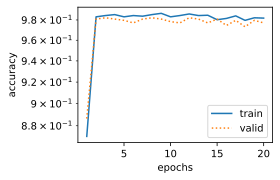

fold 0, train accuracy: 0.981824, valid accuracy: 0.977041
1 fold
n: 3136
3006.0
Train Accuracy of 1 for epoch 0 is 0.9585459183673469
n: 784
752.0
validation Accuracy of 1 for epoch 0 is 0.9591836734693877
n: 3136
3078.0
Train Accuracy of 1 for epoch 1 is 0.9815051020408163
n: 784
770.0
validation Accuracy of 1 for epoch 1 is 0.9821428571428571
n: 3136
3084.0
Train Accuracy of 1 for epoch 2 is 0.9834183673469388
n: 784
771.0
validation Accuracy of 1 for epoch 2 is 0.9834183673469388
n: 3136
3083.0
Train Accuracy of 1 for epoch 3 is 0.9830994897959183
n: 784
771.0
validation Accuracy of 1 for epoch 3 is 0.9834183673469388
n: 3136
3083.0
Train Accuracy of 1 for epoch 4 is 0.9830994897959183
n: 784
771.0
validation Accuracy of 1 for epoch 4 is 0.9834183673469388
n: 3136
3073.0
Train Accuracy of 1 for epoch 5 is 0.9799107142857143
n: 784
768.0
validation Accuracy of 1 for epoch 5 is 0.9795918367346939
n: 3136
3088.0
Train Accuracy of 1 for epoch 6 is 0.9846938775510204
n: 784
770.0
valida

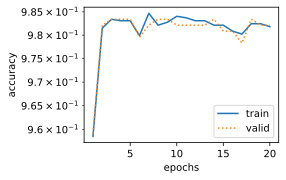

fold 1, train accuracy: 0.981824, valid accuracy: 0.982143
2 fold
n: 3136
2605.0
Train Accuracy of 2 for epoch 0 is 0.8306760204081632
n: 784
644.0
validation Accuracy of 2 for epoch 0 is 0.8214285714285714
n: 3136
3056.0
Train Accuracy of 2 for epoch 1 is 0.9744897959183674
n: 784
767.0
validation Accuracy of 2 for epoch 1 is 0.9783163265306123
n: 3136
3077.0
Train Accuracy of 2 for epoch 2 is 0.9811862244897959
n: 784
770.0
validation Accuracy of 2 for epoch 2 is 0.9821428571428571
n: 3136
3082.0
Train Accuracy of 2 for epoch 3 is 0.982780612244898
n: 784
770.0
validation Accuracy of 2 for epoch 3 is 0.9821428571428571
n: 3136
3083.0
Train Accuracy of 2 for epoch 4 is 0.9830994897959183
n: 784
772.0
validation Accuracy of 2 for epoch 4 is 0.9846938775510204
n: 3136
3089.0
Train Accuracy of 2 for epoch 5 is 0.9850127551020408
n: 784
772.0
validation Accuracy of 2 for epoch 5 is 0.9846938775510204
n: 3136
3091.0
Train Accuracy of 2 for epoch 6 is 0.9856505102040817
n: 784
772.0
validat

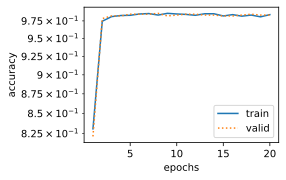

fold 2, train accuracy: 0.984056, valid accuracy: 0.983418
3 fold
n: 3136
3015.0
Train Accuracy of 3 for epoch 0 is 0.9614158163265306
n: 784
745.0
validation Accuracy of 3 for epoch 0 is 0.9502551020408163
n: 3136
3062.0
Train Accuracy of 3 for epoch 1 is 0.9764030612244898
n: 784
764.0
validation Accuracy of 3 for epoch 1 is 0.9744897959183674
n: 3136
3074.0
Train Accuracy of 3 for epoch 2 is 0.9802295918367347
n: 784
766.0
validation Accuracy of 3 for epoch 2 is 0.9770408163265306
n: 3136
3076.0
Train Accuracy of 3 for epoch 3 is 0.9808673469387755
n: 784
766.0
validation Accuracy of 3 for epoch 3 is 0.9770408163265306
n: 3136
3080.0
Train Accuracy of 3 for epoch 4 is 0.9821428571428571
n: 784
771.0
validation Accuracy of 3 for epoch 4 is 0.9834183673469388
n: 3136
3083.0
Train Accuracy of 3 for epoch 5 is 0.9830994897959183
n: 784
768.0
validation Accuracy of 3 for epoch 5 is 0.9795918367346939
n: 3136
3083.0
Train Accuracy of 3 for epoch 6 is 0.9830994897959183
n: 784
771.0
valida

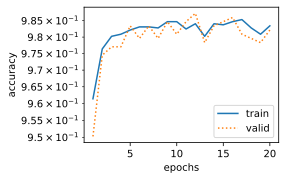

fold 3, train accuracy: 0.983418, valid accuracy: 0.982143
4 fold
n: 3136
2993.0
Train Accuracy of 4 for epoch 0 is 0.9544005102040817
n: 784
742.0
validation Accuracy of 4 for epoch 0 is 0.9464285714285714
n: 3136
3059.0
Train Accuracy of 4 for epoch 1 is 0.9754464285714286
n: 784
763.0
validation Accuracy of 4 for epoch 1 is 0.9732142857142857
n: 3136
3071.0
Train Accuracy of 4 for epoch 2 is 0.9792729591836735
n: 784
766.0
validation Accuracy of 4 for epoch 2 is 0.9770408163265306
n: 3136
3079.0
Train Accuracy of 4 for epoch 3 is 0.9818239795918368
n: 784
767.0
validation Accuracy of 4 for epoch 3 is 0.9783163265306123
n: 3136
3077.0
Train Accuracy of 4 for epoch 4 is 0.9811862244897959
n: 784
769.0
validation Accuracy of 4 for epoch 4 is 0.9808673469387755
n: 3136
3081.0
Train Accuracy of 4 for epoch 5 is 0.9824617346938775
n: 784
769.0
validation Accuracy of 4 for epoch 5 is 0.9808673469387755
n: 3136
3082.0
Train Accuracy of 4 for epoch 6 is 0.982780612244898
n: 784
769.0
validat

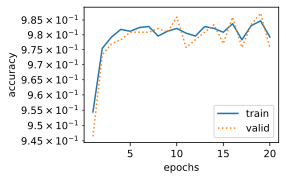

fold 4, train accuracy: 0.979273, valid accuracy: 0.975765
5-fold validation: avg train accuracy: 0.982079, avg valid accuracy: 0.980102


In [29]:
num_inputs = train_features01.shape[1]
num_outputs=2
k, num_epochs, lr, weight_decay, batch_size = 5, 20, 0.001, 0.1, 64
num_hiddens01, num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob=500,200,100, 20,"ReLU",0.1
train_l, valid_l = k_fold(k, train_features01, train_labels01, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs ,num_hiddens01, 
                          num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob)
print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f'
      % (k, train_l, valid_l))

0 fold
n: 3136
1555.0
Train Accuracy of 0 for epoch 0 is 0.4958545918367347
n: 784
395.0
validation Accuracy of 0 for epoch 0 is 0.5038265306122449
n: 3136
1555.0
Train Accuracy of 0 for epoch 1 is 0.4958545918367347
n: 784
395.0
validation Accuracy of 0 for epoch 1 is 0.5038265306122449
n: 3136
1555.0
Train Accuracy of 0 for epoch 2 is 0.4958545918367347
n: 784
395.0
validation Accuracy of 0 for epoch 2 is 0.5038265306122449
n: 3136
1555.0
Train Accuracy of 0 for epoch 3 is 0.4958545918367347
n: 784
395.0
validation Accuracy of 0 for epoch 3 is 0.5038265306122449
n: 3136
1555.0
Train Accuracy of 0 for epoch 4 is 0.4958545918367347
n: 784
395.0
validation Accuracy of 0 for epoch 4 is 0.5038265306122449
n: 3136
1555.0
Train Accuracy of 0 for epoch 5 is 0.4958545918367347
n: 784
395.0
validation Accuracy of 0 for epoch 5 is 0.5038265306122449
n: 3136
1555.0
Train Accuracy of 0 for epoch 6 is 0.4958545918367347
n: 784
395.0
validation Accuracy of 0 for epoch 6 is 0.5038265306122449
n: 313

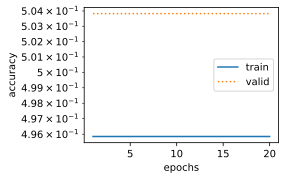

fold 0, train accuracy: 0.495855, valid accuracy: 0.503827
1 fold
n: 3136
1536.0
Train Accuracy of 1 for epoch 0 is 0.4897959183673469
n: 784
414.0
validation Accuracy of 1 for epoch 0 is 0.5280612244897959
n: 3136
1536.0
Train Accuracy of 1 for epoch 1 is 0.4897959183673469
n: 784
414.0
validation Accuracy of 1 for epoch 1 is 0.5280612244897959
n: 3136
1536.0
Train Accuracy of 1 for epoch 2 is 0.4897959183673469
n: 784
414.0
validation Accuracy of 1 for epoch 2 is 0.5280612244897959
n: 3136
1536.0
Train Accuracy of 1 for epoch 3 is 0.4897959183673469
n: 784
414.0
validation Accuracy of 1 for epoch 3 is 0.5280612244897959
n: 3136
1536.0
Train Accuracy of 1 for epoch 4 is 0.4897959183673469
n: 784
414.0
validation Accuracy of 1 for epoch 4 is 0.5280612244897959
n: 3136
1536.0
Train Accuracy of 1 for epoch 5 is 0.4897959183673469
n: 784
414.0
validation Accuracy of 1 for epoch 5 is 0.5280612244897959
n: 3136
1536.0
Train Accuracy of 1 for epoch 6 is 0.4897959183673469
n: 784
414.0
valida

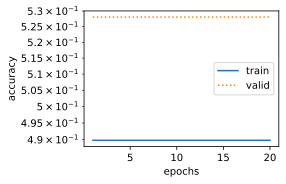

fold 1, train accuracy: 0.489796, valid accuracy: 0.528061
2 fold
n: 3136
1590.0
Train Accuracy of 2 for epoch 0 is 0.5070153061224489
n: 784
380.0
validation Accuracy of 2 for epoch 0 is 0.4846938775510204
n: 3136
1590.0
Train Accuracy of 2 for epoch 1 is 0.5070153061224489
n: 784
380.0
validation Accuracy of 2 for epoch 1 is 0.4846938775510204
n: 3136
1590.0
Train Accuracy of 2 for epoch 2 is 0.5070153061224489
n: 784
380.0
validation Accuracy of 2 for epoch 2 is 0.4846938775510204
n: 3136
1590.0
Train Accuracy of 2 for epoch 3 is 0.5070153061224489
n: 784
380.0
validation Accuracy of 2 for epoch 3 is 0.4846938775510204
n: 3136
1590.0
Train Accuracy of 2 for epoch 4 is 0.5070153061224489
n: 784
380.0
validation Accuracy of 2 for epoch 4 is 0.4846938775510204
n: 3136
1590.0
Train Accuracy of 2 for epoch 5 is 0.5070153061224489
n: 784
380.0
validation Accuracy of 2 for epoch 5 is 0.4846938775510204
n: 3136
1590.0
Train Accuracy of 2 for epoch 6 is 0.5070153061224489
n: 784
380.0
valida

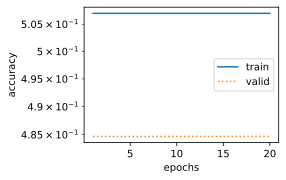

fold 2, train accuracy: 0.507015, valid accuracy: 0.484694
3 fold
n: 3136
1602.0
Train Accuracy of 3 for epoch 0 is 0.5108418367346939
n: 784
348.0
validation Accuracy of 3 for epoch 0 is 0.44387755102040816
n: 3136
1602.0
Train Accuracy of 3 for epoch 1 is 0.5108418367346939
n: 784
348.0
validation Accuracy of 3 for epoch 1 is 0.44387755102040816
n: 3136
1602.0
Train Accuracy of 3 for epoch 2 is 0.5108418367346939
n: 784
348.0
validation Accuracy of 3 for epoch 2 is 0.44387755102040816
n: 3136
1602.0
Train Accuracy of 3 for epoch 3 is 0.5108418367346939
n: 784
348.0
validation Accuracy of 3 for epoch 3 is 0.44387755102040816
n: 3136
1602.0
Train Accuracy of 3 for epoch 4 is 0.5108418367346939
n: 784
348.0
validation Accuracy of 3 for epoch 4 is 0.44387755102040816
n: 3136
1602.0
Train Accuracy of 3 for epoch 5 is 0.5108418367346939
n: 784
348.0
validation Accuracy of 3 for epoch 5 is 0.44387755102040816
n: 3136
1602.0
Train Accuracy of 3 for epoch 6 is 0.5108418367346939
n: 784
348.0


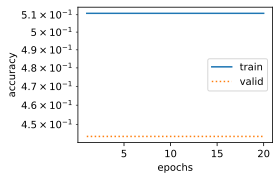

fold 3, train accuracy: 0.510842, valid accuracy: 0.443878
4 fold
n: 3136
1561.0
Train Accuracy of 4 for epoch 0 is 0.49776785714285715
n: 784
389.0
validation Accuracy of 4 for epoch 0 is 0.4961734693877551
n: 3136
1561.0
Train Accuracy of 4 for epoch 1 is 0.49776785714285715
n: 784
389.0
validation Accuracy of 4 for epoch 1 is 0.4961734693877551
n: 3136
1561.0
Train Accuracy of 4 for epoch 2 is 0.49776785714285715
n: 784
389.0
validation Accuracy of 4 for epoch 2 is 0.4961734693877551
n: 3136
1561.0
Train Accuracy of 4 for epoch 3 is 0.49776785714285715
n: 784
389.0
validation Accuracy of 4 for epoch 3 is 0.4961734693877551
n: 3136
1561.0
Train Accuracy of 4 for epoch 4 is 0.49776785714285715
n: 784
389.0
validation Accuracy of 4 for epoch 4 is 0.4961734693877551
n: 3136
1561.0
Train Accuracy of 4 for epoch 5 is 0.49776785714285715
n: 784
389.0
validation Accuracy of 4 for epoch 5 is 0.4961734693877551
n: 3136
1561.0
Train Accuracy of 4 for epoch 6 is 0.49776785714285715
n: 784
389.0

KeyboardInterrupt: 

In [28]:
num_inputs = train_features01.shape[1]
num_outputs=2
k, num_epochs, lr, weight_decay, batch_size = 5, 20, 0.001, 0.1, 64
num_hiddens01, num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob=60,30,10,2,"ReLU",0.1
train_l, valid_l = k_fold(k, train_features01, train_labels01, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs ,num_hiddens01, 
                          num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob)
print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f'
      % (k, train_l, valid_l))

## Prediction

In [24]:
def train_and_pred(train_feature, test_feature, train_label,test_label,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,num_hiddens04,active_function,drop_prob)
    train_ls, _ = train(net,0,train_feature, train_label, None,None,
          num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'accuracy')
    print('train Accuracy %f' % train_ls[-1])
    # Apply the network to the test set
    preds = F.softmax(net(test_feature),dim=1).detach().numpy()
    acc=evaluate_accuracy(net,test_feature,test_label)
    #print(type(preds))
    print("test acc=",acc)
    print(preds)
    return(preds)

n: 3923
3789.0
Train Accuracy of 0 for epoch 0 is 0.9658424674993628
n: 3923
3838.0
Train Accuracy of 0 for epoch 1 is 0.9783329084884017
n: 3923
3818.0
Train Accuracy of 0 for epoch 2 is 0.9732347693092022
n: 3923
3863.0
Train Accuracy of 0 for epoch 3 is 0.9847055824624013
n: 3923
3864.0
Train Accuracy of 0 for epoch 4 is 0.9849604894213612
n: 3923
3858.0
Train Accuracy of 0 for epoch 5 is 0.9834310476676014
n: 3923
3847.0
Train Accuracy of 0 for epoch 6 is 0.9806270711190416
n: 3923
3852.0
Train Accuracy of 0 for epoch 7 is 0.9819016059138415
n: 3923
3856.0
Train Accuracy of 0 for epoch 8 is 0.9829212337496813
n: 3923
3865.0
Train Accuracy of 0 for epoch 9 is 0.9852153963803212
n: 3923
3833.0
Train Accuracy of 0 for epoch 10 is 0.9770583736936018
n: 3923
3866.0
Train Accuracy of 0 for epoch 11 is 0.9854703033392812
n: 3923
3859.0
Train Accuracy of 0 for epoch 12 is 0.9836859546265613
n: 3923
3848.0
Train Accuracy of 0 for epoch 13 is 0.9808819780780015
n: 3923
3856.0
Train Accuracy 

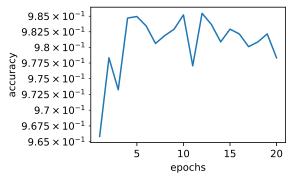

train Accuracy 0.978333
n: 693
442.0
test acc= 0.6378066378066378
[[0.41676813 0.58323187]
 [0.35043412 0.6495659 ]
 [0.03937238 0.9606277 ]
 ...
 [0.7009301  0.29906997]
 [0.84440327 0.15559664]
 [0.56051356 0.4394864 ]]


In [30]:
pre=train_and_pred(train_features01, test_features, train_labels01 ,test_labels01,
               num_epochs, lr, weight_decay, batch_size)
pr=np.array(pre) 
pred=pr[:,1]

<Figure size 252x180 with 0 Axes>

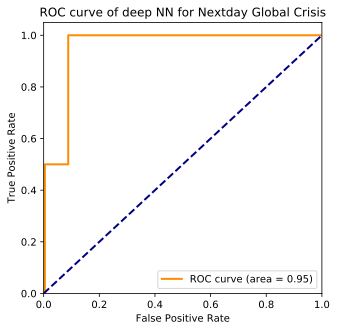

In [37]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(test_labels01,pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.title('ROC curve of deep NN for Nextday Global Crisis')
plt.show()
#print("pred",y_pred)

In [35]:
confusion_matrix((pred> 0.5).astype('int'),test_labels01)

array([[435,   0],
       [256,   2]], dtype=int64)

In [36]:
confusion_matrix((pred> 0.7).astype('int'),test_labels01)

array([[538,   0],
       [153,   2]], dtype=int64)

# Global 20 prediction

## Modelling

In [38]:
class Net20(nn.Module):
    def __init__(self, num_inputs, num_outputs ,num_hiddens01, num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob,is_training = True):
        super(Net20, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens01 = num_hiddens01
        self.num_hiddens02 = num_hiddens02
        self.num_hiddens03 = num_hiddens03
        self.num_hiddens04 = num_hiddens04
        self.drop_prob = drop_prob     
        self.is_training = is_training 
        
        self.linear_1 = nn.Linear(num_inputs, num_hiddens01)
        self.linear_2 = nn.Linear(num_hiddens01, num_hiddens02)
        self.linear_3 = nn.Linear(num_hiddens02, num_hiddens03)
        self.linear_4 = nn.Linear(num_hiddens03, num_hiddens04)
        self.linear_5 = nn.Linear(num_hiddens04, num_outputs)
        
        if active_function=="ReLU":
            self.active = nn.ReLU()
        elif active_function=="sigmoid":
            self.active = nn.Sigmoid()
        elif active_function=="Tanh":
            self.active = nn.Tanh()
    
    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1= self.linear_1(X)
        
        nn.BatchNorm1d(self.num_inputs)
        #if self.is_training == True:
            # Add a dropout layer after the first fully connected layer
        #    H1 = dropout(H1, drop_prob)
        H1 = self.active(H1)
        
        H2 = self.linear_2(H1)
        nn.BatchNorm1d(self.num_hiddens02)
        H2 = self.active(H2)
        
        H3 = self.linear_3(H2)
        nn.BatchNorm1d(self.num_hiddens03)
        H3 = self.active(H3)
        
        H4 = self.linear_4(H3)
        H4 = dropout(H4, self.drop_prob)
        out = self.linear_5(H4)
        return out

In [39]:
loss = nn.CrossEntropyLoss()
in_features = train_features20.shape[1]
def get_net(num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03, num_hiddens04, active_function,drop_prob):
    if( num_hiddens01<num_hiddens02 or num_hiddens02 < num_hiddens03 or num_hiddens03 < num_hiddens04):
        print("Wrong Hidden layers")
        net=False
    else:
        net=Net20(num_inputs, num_outputs ,num_hiddens01, num_hiddens02, num_hiddens03, num_hiddens04, active_function,drop_prob)
    return net

0 fold
n: 3136
2935.0
Train Accuracy of 0 for epoch 0 is 0.935905612244898
n: 784
735.0
validation Accuracy of 0 for epoch 0 is 0.9375
n: 3136
3044.0
Train Accuracy of 0 for epoch 1 is 0.9706632653061225
n: 784
754.0
validation Accuracy of 0 for epoch 1 is 0.9617346938775511
n: 3136
3045.0
Train Accuracy of 0 for epoch 2 is 0.9709821428571429
n: 784
757.0
validation Accuracy of 0 for epoch 2 is 0.9655612244897959
n: 3136
3031.0
Train Accuracy of 0 for epoch 3 is 0.9665178571428571
n: 784
750.0
validation Accuracy of 0 for epoch 3 is 0.9566326530612245
n: 3136
3033.0
Train Accuracy of 0 for epoch 4 is 0.967155612244898
n: 784
754.0
validation Accuracy of 0 for epoch 4 is 0.9617346938775511
n: 3136
3034.0
Train Accuracy of 0 for epoch 5 is 0.9674744897959183
n: 784
749.0
validation Accuracy of 0 for epoch 5 is 0.9553571428571429
n: 3136
3051.0
Train Accuracy of 0 for epoch 6 is 0.9728954081632653
n: 784
760.0
validation Accuracy of 0 for epoch 6 is 0.9693877551020408
n: 3136
3015.0
Train

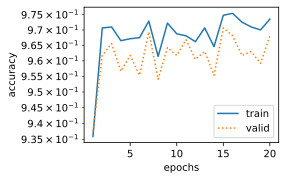

fold 0, train accuracy: 0.973533, valid accuracy: 0.968112
1 fold
n: 3136
2942.0
Train Accuracy of 1 for epoch 0 is 0.9381377551020408
n: 784
719.0
validation Accuracy of 1 for epoch 0 is 0.9170918367346939
n: 3136
3049.0
Train Accuracy of 1 for epoch 1 is 0.9722576530612245
n: 784
755.0
validation Accuracy of 1 for epoch 1 is 0.9630102040816326
n: 3136
3036.0
Train Accuracy of 1 for epoch 2 is 0.9681122448979592
n: 784
757.0
validation Accuracy of 1 for epoch 2 is 0.9655612244897959
n: 3136
3045.0
Train Accuracy of 1 for epoch 3 is 0.9709821428571429
n: 784
754.0
validation Accuracy of 1 for epoch 3 is 0.9617346938775511
n: 3136
3050.0
Train Accuracy of 1 for epoch 4 is 0.9725765306122449
n: 784
758.0
validation Accuracy of 1 for epoch 4 is 0.9668367346938775
n: 3136
3048.0
Train Accuracy of 1 for epoch 5 is 0.9719387755102041
n: 784
754.0
validation Accuracy of 1 for epoch 5 is 0.9617346938775511
n: 3136
3053.0
Train Accuracy of 1 for epoch 6 is 0.9735331632653061
n: 784
756.0
valida

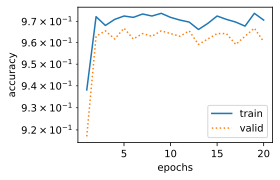

fold 1, train accuracy: 0.970663, valid accuracy: 0.960459
2 fold
n: 3136
2935.0
Train Accuracy of 2 for epoch 0 is 0.935905612244898
n: 784
736.0
validation Accuracy of 2 for epoch 0 is 0.9387755102040817
n: 3136
3028.0
Train Accuracy of 2 for epoch 1 is 0.9655612244897959
n: 784
763.0
validation Accuracy of 2 for epoch 1 is 0.9732142857142857
n: 3136
3040.0
Train Accuracy of 2 for epoch 2 is 0.9693877551020408
n: 784
764.0
validation Accuracy of 2 for epoch 2 is 0.9744897959183674
n: 3136
3045.0
Train Accuracy of 2 for epoch 3 is 0.9709821428571429
n: 784
768.0
validation Accuracy of 2 for epoch 3 is 0.9795918367346939
n: 3136
3042.0
Train Accuracy of 2 for epoch 4 is 0.9700255102040817
n: 784
764.0
validation Accuracy of 2 for epoch 4 is 0.9744897959183674
n: 3136
3045.0
Train Accuracy of 2 for epoch 5 is 0.9709821428571429
n: 784
766.0
validation Accuracy of 2 for epoch 5 is 0.9770408163265306
n: 3136
3026.0
Train Accuracy of 2 for epoch 6 is 0.9649234693877551
n: 784
766.0
validat

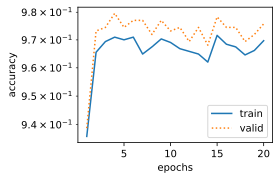

fold 2, train accuracy: 0.969707, valid accuracy: 0.975765
3 fold
n: 3136
2896.0
Train Accuracy of 3 for epoch 0 is 0.923469387755102
n: 784
716.0
validation Accuracy of 3 for epoch 0 is 0.9132653061224489
n: 3136
3030.0
Train Accuracy of 3 for epoch 1 is 0.9661989795918368
n: 784
753.0
validation Accuracy of 3 for epoch 1 is 0.9604591836734694
n: 3136
3028.0
Train Accuracy of 3 for epoch 2 is 0.9655612244897959
n: 784
759.0
validation Accuracy of 3 for epoch 2 is 0.9681122448979592
n: 3136
3033.0
Train Accuracy of 3 for epoch 3 is 0.967155612244898
n: 784
756.0
validation Accuracy of 3 for epoch 3 is 0.9642857142857143
n: 3136
3044.0
Train Accuracy of 3 for epoch 4 is 0.9706632653061225
n: 784
761.0
validation Accuracy of 3 for epoch 4 is 0.9706632653061225
n: 3136
3036.0
Train Accuracy of 3 for epoch 5 is 0.9681122448979592
n: 784
755.0
validation Accuracy of 3 for epoch 5 is 0.9630102040816326
n: 3136
3024.0
Train Accuracy of 3 for epoch 6 is 0.9642857142857143
n: 784
761.0
validati

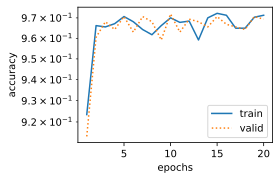

fold 3, train accuracy: 0.971301, valid accuracy: 0.969388
4 fold
n: 3136
2815.0
Train Accuracy of 4 for epoch 0 is 0.8976403061224489
n: 784
703.0
validation Accuracy of 4 for epoch 0 is 0.8966836734693877
n: 3136
3039.0
Train Accuracy of 4 for epoch 1 is 0.9690688775510204
n: 784
755.0
validation Accuracy of 4 for epoch 1 is 0.9630102040816326
n: 3136
3049.0
Train Accuracy of 4 for epoch 2 is 0.9722576530612245
n: 784
763.0
validation Accuracy of 4 for epoch 2 is 0.9732142857142857
n: 3136
3055.0
Train Accuracy of 4 for epoch 3 is 0.9741709183673469
n: 784
764.0
validation Accuracy of 4 for epoch 3 is 0.9744897959183674
n: 3136
3049.0
Train Accuracy of 4 for epoch 4 is 0.9722576530612245
n: 784
762.0
validation Accuracy of 4 for epoch 4 is 0.9719387755102041
n: 3136
3044.0
Train Accuracy of 4 for epoch 5 is 0.9706632653061225
n: 784
761.0
validation Accuracy of 4 for epoch 5 is 0.9706632653061225
n: 3136
3017.0
Train Accuracy of 4 for epoch 6 is 0.9620535714285714
n: 784
756.0
valida

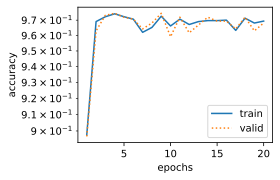

fold 4, train accuracy: 0.969388, valid accuracy: 0.968112
5-fold validation: avg train accuracy: 0.970918, avg valid accuracy: 0.968367


In [51]:
num_inputs = train_features20.shape[1]
num_outputs=2
k, num_epochs, lr, weight_decay, batch_size = 5, 20, 0.001, 0.1, 64
num_hiddens01, num_hiddens02,num_hiddens03,num_hiddens04, active_function,drop_prob,=500, 300, 100, 50,"ReLU",0.5
train_l, valid_l = k_fold(k, train_features20, train_labels20, num_epochs, lr,
                          weight_decay, batch_size,num_inputs, num_outputs ,num_hiddens01, num_hiddens02,num_hiddens03,num_hiddens04, active_function,drop_prob)
print('%d-fold validation: avg train accuracy: %f, avg valid accuracy: %f'
      % (k, train_l, valid_l))

n: 3923
3590.0
Train Accuracy of 0 for epoch 0 is 0.9151159826663268
n: 3923
3780.0
Train Accuracy of 0 for epoch 1 is 0.9635483048687229
n: 3923
3782.0
Train Accuracy of 0 for epoch 2 is 0.9640581187866428
n: 3923
3780.0
Train Accuracy of 0 for epoch 3 is 0.9635483048687229
n: 3923
3800.0
Train Accuracy of 0 for epoch 4 is 0.9686464440479226
n: 3923
3800.0
Train Accuracy of 0 for epoch 5 is 0.9686464440479226
n: 3923
3802.0
Train Accuracy of 0 for epoch 6 is 0.9691562579658425
n: 3923
3810.0
Train Accuracy of 0 for epoch 7 is 0.9711955136375223
n: 3923
3811.0
Train Accuracy of 0 for epoch 8 is 0.9714504205964822
n: 3923
3797.0
Train Accuracy of 0 for epoch 9 is 0.9678817231710426
n: 3923
3796.0
Train Accuracy of 0 for epoch 10 is 0.9676268162120826
n: 3923
3793.0
Train Accuracy of 0 for epoch 11 is 0.9668620953352026
n: 3923
3799.0
Train Accuracy of 0 for epoch 12 is 0.9683915370889625
n: 3923
3807.0
Train Accuracy of 0 for epoch 13 is 0.9704307927606424
n: 3923
3804.0
Train Accuracy 

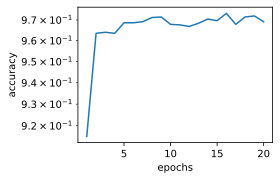

train Accuracy 0.969156
n: 693
401.0
test acc= 0.5786435786435786
[[0.80933106 0.19066894]
 [0.91754925 0.08245077]
 [0.14195329 0.8580467 ]
 ...
 [0.83000046 0.16999954]
 [0.91568434 0.08431569]
 [0.45940992 0.5405901 ]]


In [52]:
pre20=train_and_pred(train_features20, test_features, train_labels20 ,test_labels20,
               num_epochs, lr, weight_decay, batch_size)
pr20=np.array(pre20) 
pred20=pr20[:,1]

<Figure size 252x180 with 0 Axes>

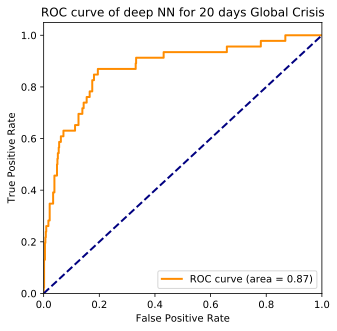

In [53]:
fpr, tpr, threshold = roc_curve(test_labels20,pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.title('ROC curve of deep NN for 20 days Global Crisis')
plt.show()
#print("pred",y_pred)

In [54]:
confusion_matrix((pred20> 0.5).astype('int'),test_labels20)

array([[355,   0],
       [292,  46]], dtype=int64)

In [55]:
confusion_matrix((pred20> 0.7).astype('int'),test_labels20)

array([[433,   0],
       [214,  46]], dtype=int64)